### 01- Biuld

In [1]:
import subprocess, os, shutil, itertools, re, textwrap, time
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

ROOT  = Path(".").resolve()
BUILD = ROOT / "build"

SERIAL_EXE = "./serial"
OPENMP_EXE = "./openmp"
CUDA_EXE   = "./cuda"


### 02 - helpers de build/exec

In [2]:
def run(cmd, workdir=ROOT, env=None):
    t0 = time.perf_counter()
    res = subprocess.run(cmd, shell=True, cwd=workdir,
                         env=env, text=True, capture_output=True)
    return res.stdout + res.stderr, res.returncode, time.perf_counter() - t0

def cmake_config(cmake_opts=""):
    if BUILD.exists():
        shutil.rmtree(BUILD)
    BUILD.mkdir()
    out, rc, _ = run(f"cmake .. -DCMAKE_BUILD_TYPE=Release {cmake_opts}", BUILD)
    if rc:
        raise RuntimeError(out)

def make():
    out, rc, _ = run("make -j$(nproc)", BUILD)
    if rc:
        raise RuntimeError(out)

def parse_time(log, key):
    pat = rf"(?im)^[ \t]*{key}:[ \t]*([0-9]+(?:\.[0-9]+)?)\s*$"
    m = re.search(pat, log)
    if not m:
        raise ValueError(f"⛔ não achei tempo para '{key}'.\nSaída:\n{log}")
    return float(m.group(1))


### wrappers runtime

In [3]:
def run_serial():   return parse_time(run(SERIAL_EXE, BUILD)[0], "serial")
def run_openmp(nt):
    env = os.environ.copy(); env["OMP_NUM_THREADS"] = str(nt)
    return parse_time(run(OPENMP_EXE, BUILD, env)[0], "openmp")

def run_cuda(bx, by):
    env = os.environ.copy()
    env["BLOCK_X"], env["BLOCK_Y"] = str(bx), str(by)
    return parse_time(run(CUDA_EXE, BUILD, env)[0], "cuda")

### benchmark

In [4]:
def bench(tile_list=(32,), tb_list=(1,),
          nthreads=(1,2,4,8),
          blocks=((32,8),(32,16)),
          nrep=3):

    rows = []

    for tile, tb in itertools.product(tile_list, tb_list):

        base_flags = f"-DTILE={tile} -DTB={tb}"
        cmake_config(base_flags)
        make()

        t_ser = min(run_serial() for _ in range(nrep))
        tag   = f"T{tile}_TB{tb}"
        rows.append({"variant":"serial", "cfg":tag, "param":"-", "time":t_ser, "speedup":1.0})

        for nt in nthreads:
            t = min(run_openmp(nt) for _ in range(nrep))
            rows.append({"variant":"openmp", "cfg":tag,
                         "param":f"{nt} thr", "time":t, "speedup":t_ser/t})

        for bx, by in blocks:
            flags = f"{base_flags} -DBLOCK_X={bx} -DBLOCK_Y={by}"
            cmake_config(flags)
            make()
            t = min(run_cuda(bx, by) for _ in range(nrep))
            rows.append({
                "variant": "cuda",
                "cfg": tag,
                "param": f"{bx}x{by}",
                "time": t,
                "speedup": (t_ser / t) if t > 0 else float("inf")
            })


    return pd.DataFrame(rows)

In [5]:
df = bench(
    tile_list=(16,32),        # cache-blocking 16 e 32
    tb_list=(1,2),            # temporal-blocking 1 ou 2 iterações
    nthreads=(2,4,8),         # CPUs
    blocks=((16,16),(32,8)),  # CUDA blocos
    nrep=3
)

In [6]:
df

variant      cfg  param      time     speedup
0   serial  T16_TB1      -  5.187831    1.000000
1   openmp  T16_TB1  2 thr  0.754284    6.877822
2   openmp  T16_TB1  4 thr  0.696245    7.451157
3   openmp  T16_TB1  8 thr  0.804362    6.449622
4     cuda  T16_TB1  16x16  0.007949  652.613836
5     cuda  T16_TB1   32x8  0.008325  623.151505
6   serial  T16_TB2      -  4.068315    1.000000
7   openmp  T16_TB2  2 thr  0.700275    5.809596
8   openmp  T16_TB2  4 thr  0.718028    5.665956
9   openmp  T16_TB2  8 thr  0.723618    5.622186
10    cuda  T16_TB2  16x16  0.007864  517.313004
11    cuda  T16_TB2   32x8  0.007842  518.799147
12  serial  T32_TB1      -  2.448072    1.000000
13  openmp  T32_TB1  2 thr  0.626794    3.905704
14  openmp  T32_TB1  4 thr  0.654713    3.739153
15  openmp  T32_TB1  8 thr  0.733039    3.339620
16    cuda  T32_TB1  16x16  0.007938  308.397228
17    cuda  T32_TB1   32x8  0.008332  293.805495
18  serial  T32_TB2      -  3.334145    1.000000
19  openmp  T32_TB2  2 thr  0.566066    5.890029
20  openmp  T32_TB2  4 thr  0.566626    5.884208
21  openmp  T32_TB2  8 thr  0.628026    5.308928
22    cuda  T32_TB2  16x16  0.007343  454.067005
23    cuda  T32_TB2   32x8  0.006810  489.605801

### Graph plot

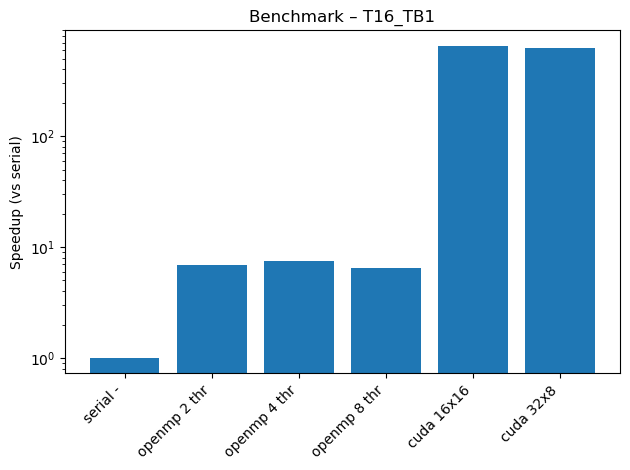

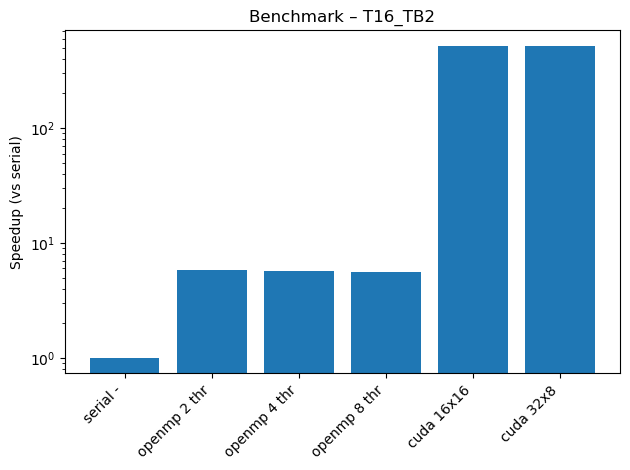

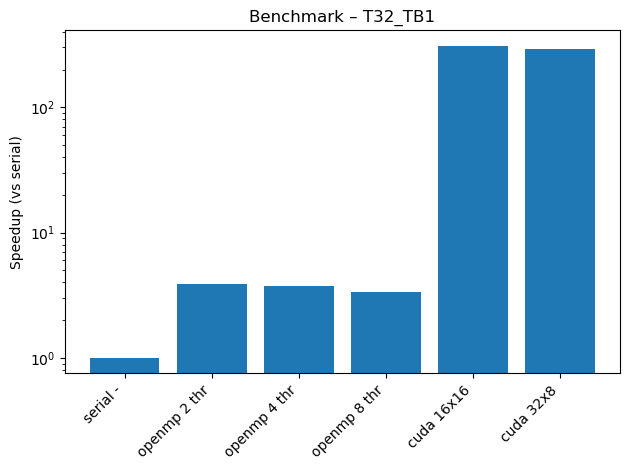

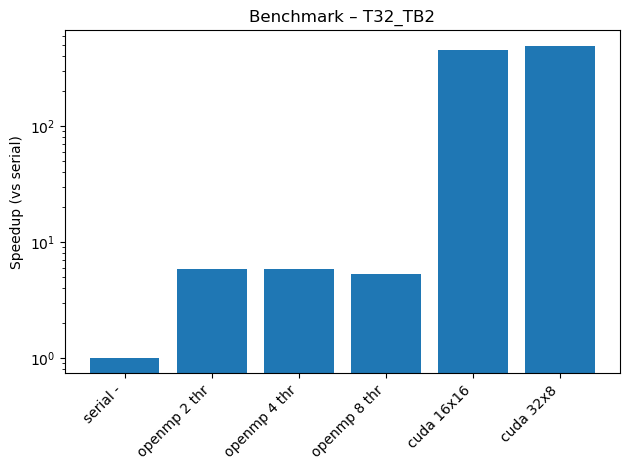

In [7]:

for cfg, subset in df.groupby('cfg'):
    labels = [f"{v} {p}" for v, p in zip(subset["variant"], subset["param"])]
    plt.figure()
    plt.bar(labels, subset["speedup"])
    plt.yscale("log")  # escala log para ver desde 1× até 600×
    plt.ylabel("Speedup (vs serial)")
    plt.title(f"Benchmark – {cfg}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

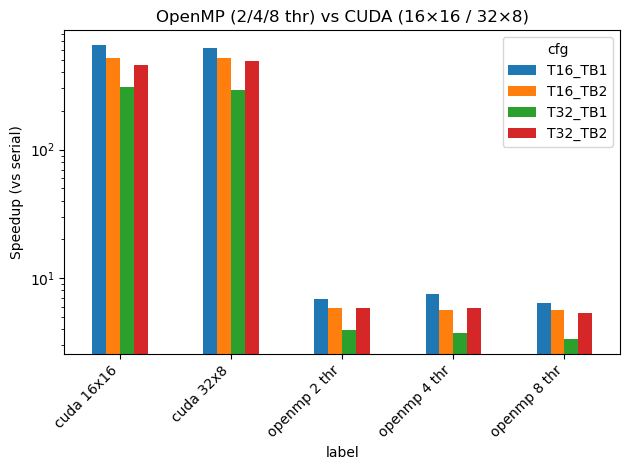

In [8]:
# Mantém apenas openmp e cuda
df_plot = df[df["variant"].isin(["openmp", "cuda"])].copy()
df_plot["label"] = df_plot["variant"] + " " + df_plot["param"]

# Pivot: linhas são labels, colunas são cfg, valores são speedup
pivot = df_plot.pivot(index="label", columns="cfg", values="speedup")

# Plot
plt.figure()
pivot.plot(kind="bar", logy=True)
plt.ylabel("Speedup (vs serial)")
plt.title("OpenMP (2/4/8 thr) vs CUDA (16×16 / 32×8)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [13]:
import numpy as np
import plotly.graph_objects as go
from pathlib import Path

def animate_wave(data_dir="data", prefix="wave", nx=100, duration=100):
    data_dir = Path(data_dir)
    files = sorted(data_dir.glob(f"{prefix}_*.dat"))

    if not files:
        raise FileNotFoundError(f"No files matching {prefix}_*.dat in {data_dir}")

    # Primeiro frame
    z0 = np.loadtxt(files[0])[:, 2].reshape(nx, nx)

    # Frames da animação
    frames = []
    for f in files:
        z = np.loadtxt(f)[:, 2].reshape(nx, nx)
        frames.append(go.Frame(data=[go.Heatmap(z=z)], name=f.stem))

    # Figura com controles
    fig = go.Figure(
        data=[go.Heatmap(z=z0)],
        frames=frames,
        layout=go.Layout(
            title="Wave propagation",
            width=600,
            height=600,
            updatemenus=[{
                "type": "buttons",
                "buttons": [{
                    "label": "Play",
                    "method": "animate",
                    "args": [None, {"frame": {"duration": duration, "redraw": True}}]
                }]
            }]
        )
    )

    fig.show()


In [14]:
animate_wave(data_dir="data", prefix="wave", nx=100, duration=80)

In [11]:
animate_wave(data_dir="data", prefix="wave_0001", nx=100, duration=80)